In [86]:
# Path


from dataclasses import dataclass


@dataclass
class Path:
    """
    Dataclass describing a path using:
    * list of point indices;
    * path length;
    * path name (optional).
    """

    indx: list[int]
    leng: float
    name: str

In [87]:
# Travelling Salesman Problem


from random import randint
from numpy import array
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backend_bases import PickEvent


def generate_problem(count: int, canvas_size: int = 1000) -> list[tuple[int]]:
    """Generates a list of random 2D points."""

    return [(randint(0, canvas_size), randint(0, canvas_size)) for _ in range(count)]


class TSP:
    """
    Allows to visualize the Traveling Salesman Problem and paths.
    """

    CLR_POINT = "#eb343a"
    CLR_PATH = [
        "#eb343a",
        "#db34eb",
        "#5b34eb",
        "#34b4eb",
        "#34eb4c",
        "#ebe534",
        "#eb9234",
    ]

    def __init__(self, points: list[tuple[int]], paths: list[Path] = None) -> None:
        """Initializes the problem, outputs its data using graphics."""

        self.__points = points
        self.__paths = paths
        self.__fig, self.__ax = plt.subplots(num=f"Travelling Salesman Problem")
        self.__show()

    def get_points(self) -> list[tuple[int]]:
        """Getter to get the list of 2D points of the initialized problem."""

        return self.__points

    def get_paths(self) -> list[Path]:
        """Getter to get the list of paths of the initialized problem."""

        return self.__paths

    def __draw_points(self) -> None:
        """Draws 2D points and their coordinates on the canvas."""

        self.__ax.scatter(
            *array(self.__points).T,
            zorder=1,
            color=TSP.CLR_POINT,
            label=f"Points ({len(self.__points)})",
        )
        for i, p in enumerate(self.__points):
            plt.annotate(
                i + 1,
                p,
                ha="center",
                textcoords="offset points",
                xytext=(0, 4),
                fontsize=8,
            )
            plt.annotate(
                f"({p[0]}; {p[1]})",
                p,
                ha="center",
                va="top",
                textcoords="offset points",
                xytext=(0, -4),
                fontsize=6,
            )

    def __draw_paths(self) -> list[Line2D]:
        """Draws all given paths on the canvas."""

        lines = []
        if self.__paths:
            for i, path in enumerate(self.__paths):
                points = [self.__points[i] for i in path.indx]
                (l,) = plt.plot(
                    *array(points).T,
                    ls="--",
                    zorder=0,
                    color=TSP.CLR_PATH[i % len(TSP.CLR_PATH)],
                    label=f"{path.name} ({path.leng:.2f})",
                )
                lines.append(l)
        return lines

    def __draw_legend(self, lines: list[Line2D]) -> None:
        """Draws the legend on the canvas."""

        if lines:
            self.__ax.set_title(
                "Tip: Click on the legend line(s) to turn the path ON / OFF",
                fontsize=10,
                loc="left",
            )
            legend = self.__ax.legend()
            lined = {}
            for legline, origline in zip(legend.get_lines(), lines):
                legline.set_picker(True)
                lined[legline] = origline

            def on_pick(event: PickEvent) -> None:
                legline = event.artist
                origline = lined[legline]
                visible = not origline.get_visible()
                origline.set_visible(visible)
                legline.set_alpha(1.0 if visible else 0.2)
                self.__fig.canvas.draw()

            self.__fig.canvas.mpl_connect("pick_event", on_pick)
        else:
            self.__ax.legend()

    def __show(self) -> None:
        """Shows the canvas with the drawn data."""

        self.__draw_points()
        lines = self.__draw_paths()
        self.__draw_legend(lines=lines)
        plt.show()


if __name__ == "__main__":
    pass

In [88]:
# Base


from math import sqrt


class Base:
    """
    The base class for path finding algorithms.
    Contains common functions.
    """

    @staticmethod
    def __euclidean_dist(a: tuple[int], b: tuple[int]) -> float:
        """Calculates the Euclidean distance between two 2D points."""

        return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    @staticmethod
    def _calculate_dist(dm: list[list[float]], indx: list[int]) -> float:
        """Calculates the path length based on the index list of the distance matrix."""

        dist = 0
        for i in range(len(indx) - 1):
            dist += dm[indx[i]][indx[i + 1]]
        return dist

    @staticmethod
    def _distance_matrix(points: list[tuple[int]]) -> list[list[float]]:
        """Calculates the distance matrix for the given 2D points."""

        return [[Base.__euclidean_dist(a, b) for b in points] for a in points]
    


In [89]:
# Simulated Annealing


# from math import exp
from numpy import exp
from random import sample, random


class SA(Base):
    """
    Simulated annealing is a probabilistic technique for approximating the global optimum of a given function.
    Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem.\n
    -----
    `iter: int` THE NUMBER OF ITERATIONS\n
    The maximum number of iterations of the algorithm.\n
    -----
    `t: int` INITIAL TEMPERATURE\n
    The initial temperature for the search decreases with the progress of the search.\n
    -----
    `g: float` CHANGE COEFFICIENT\n
    The coefficient affecting temperature change.\n
    """

    def __init__(self, iter: int, t: int, g: float) -> None:
        """Initializes the hyperparameters for the algorithm."""

        self.iter = iter
        self.t = t
        self.g = g

    def is_acceptable(self, prb_leng: float, tmp_leng: float) -> bool:
        """Checks if the state transition will execute."""
        delta = prb_leng - tmp_leng
        
        # Если новое решение лучше (меньшая длина), всегда принимаем
        if delta < 0:
            return True
        
        # Если температура очень низкая, отклоняем худшие решения
        if self.t < 1e-10:
            return False
        
        # Защита от переполнения exp
        exponent = -delta / self.t
        
        # Если exponent слишком большой, prob будет близко к 0
        if exponent < -700:  # exp(-700) уже очень близко к 0
            return False
        
        # Если exponent слишком большой положительный, prob будет 1
        if exponent > 700:   # exp(700) вызывает overflow
            return True
        
        prob = min(1.0, exp(exponent))
        return prob > random()

    def run(self, points: list[tuple[int]], name: str = None) -> Path:
        """Runs the algorithm for the given 2D points."""

        l = len(points)
        dm = SA._distance_matrix(points)
        tmp_indx = [i for i in range(l)] + [0]
        tmp_leng = SA._calculate_dist(dm, tmp_indx)
        res_indx = tmp_indx.copy()
        res_leng = tmp_leng
        for _ in range(self.iter):
            i, j = sample(range(1, l), 2)
            prb_indx = tmp_indx.copy()
            prb_indx[i], prb_indx[j] = prb_indx[j], prb_indx[i]
            prb_leng = SA._calculate_dist(dm, prb_indx)
            if self.is_acceptable(prb_leng, tmp_leng):
                tmp_indx = prb_indx
                tmp_leng = prb_leng
            if tmp_leng < res_leng:
                res_indx = tmp_indx
                res_leng = tmp_leng
            self.t *= self.g
        return Path(indx=res_indx, leng=res_leng, name=name)


if __name__ == "__main__":
    pass

In [90]:
# Brutal Force


from itertools import permutations


class BF(Base):
    """
    Simulated annealing is a probabilistic technique for approximating the global optimum of a given function.
    Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem.\n
    """

    def __init__(self) -> None:
        """Initializes the hyperparameters for the algorithm."""

        pass

    
    def run(self, points: list[tuple[int]], name: str = None) -> Path:
        """Runs the algorithm for the given 2D points."""

        l = len(points)
        dm = BF._distance_matrix(points)

        tmp_indx = [i for i in range(l)] + [0]
        min_distance = float('inf')

        res_indx = tmp_indx.copy()
        res_leng = min_distance
        for perm in permutations(list(range(l))):
            current_distance = BF._calculate_dist(dm, list(perm))

            if current_distance < res_leng:
                res_leng = current_distance
                res_indx = perm
        
        return Path(indx=list(res_indx) + [0], leng=res_leng, name=name)


if __name__ == "__main__":
    pass

In [91]:
# Brutal Force


class NN(Base):
    """
    Simulated annealing is a probabilistic technique for approximating the global optimum of a given function.
    Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem.\n
    """

    def __init__(self) -> None:
        """Initializes the hyperparameters for the algorithm."""

        pass

    
    def run(self, points: list[tuple[int]], name: str = None) -> Path:
        """Runs the algorithm for the given 2D points."""

        l = len(points)
        dm = NN._distance_matrix(points)
        visited = [False] * l
        route = [0]  # Начинаем с первого города
        visited[0] = True

        for _ in range(l - 1):
            last_city = route[-1]
            nearest_city = min(
                [(i, dm[last_city][i]) for i in range(l) if not visited[i]],
                key=lambda x: x[1]
            )[0]
            route.append(nearest_city)
            visited[nearest_city] = True

        route.append(0)  # Возвращаемся в начальный город
        total_distance = sum(dm[route[i]][route[i+1]] for i in range(l))
        
        
        return Path(indx=list(route) + [0], leng=total_distance, name=name)


if __name__ == "__main__":
    pass

SA time: 0.03374004364013672
BF time: 0.022015094757080078
NN time: 3.4809112548828125e-05


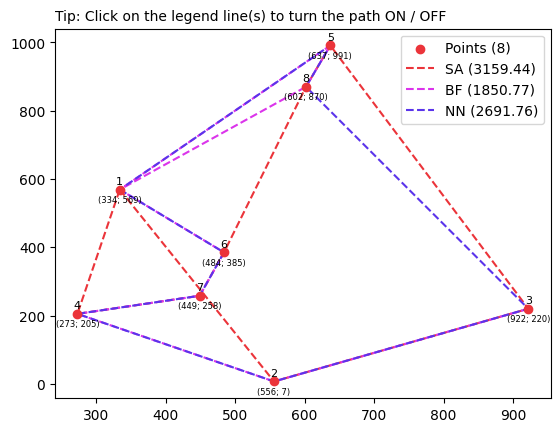

SA time: 0.04160022735595703
NN time: 0.00012373924255371094


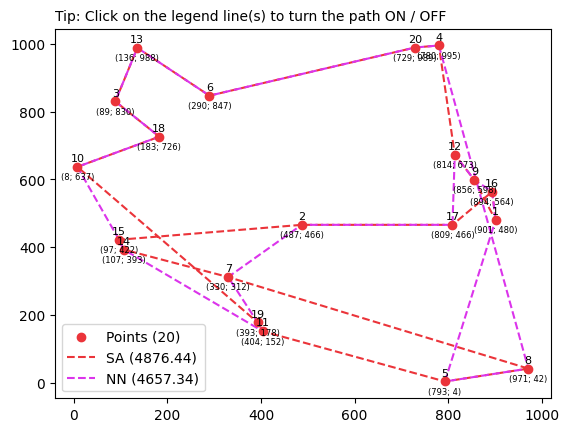

SA time: 0.10412311553955078
NN time: 0.0019299983978271484


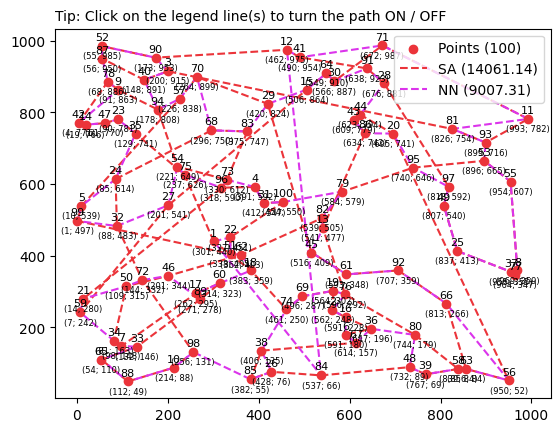

In [92]:
# Usage Examples

from time import time
import matplotlib.pyplot as plt

def small() -> None:

    points = generate_problem(8)
    paths = []

    ts = time()
    sa = SA(iter=20000, t=100, g=0.6)
    paths.append(sa.run(points=points, name="SA"))
    print(f"SA time: {time()-ts}")


    ts = time()
    bf = BF()
    paths.append(bf.run(points=points, name="BF"))
    print(f"BF time: {time()-ts}")

    ts = time()
    bf = NN()
    paths.append(bf.run(points=points, name="NN"))
    print(f"NN time: {time()-ts}")

    TSP(points=points, paths=paths)

def medium():
    points = generate_problem(20)
    paths = []

    ts = time()
    sa = SA(iter=20000, t=100, g=0.6)
    paths.append(sa.run(points=points, name="SA"))
    print(f"SA time: {time()-ts}")


    ts = time()
    bf = NN()
    paths.append(bf.run(points=points, name="NN"))
    print(f"NN time: {time()-ts}")

    TSP(points=points, paths=paths)

def large():
    points = generate_problem(100)
    paths = []

    ts = time()
    sa = SA(iter=20000, t=100, g=0.6)
    paths.append(sa.run(points=points, name="SA"))
    print(f"SA time: {time()-ts}")
    
    ts = time()
    bf = NN()
    paths.append(bf.run(points=points, name="NN"))
    print(f"NN time: {time()-ts}")

    TSP(points=points, paths=paths)

def main() -> None:
    """Tests performance of algorithms."""

    small()
    medium()
    large()


if __name__ == "__main__":
    main()

In [93]:
import time
import matplotlib.pyplot as plt
import pandas as pd

class SAWithConvergence(SA):
    def run_with_convergence(self, points: list[tuple[int]], name: str = None):
        """Runs the algorithm for the given 2D points with convergence tracking."""
        l = len(points)
        dm = SA._distance_matrix(points)
        tmp_indx = [i for i in range(l)] + [0]
        tmp_leng = SA._calculate_dist(dm, tmp_indx)
        res_indx = tmp_indx.copy()
        res_leng = tmp_leng
        
        convergence_data = []
        
        for iteration in range(self.iter):
            i, j = sample(range(1, l), 2)
            prb_indx = tmp_indx.copy()
            prb_indx[i], prb_indx[j] = prb_indx[j], prb_indx[i]
            prb_leng = SA._calculate_dist(dm, prb_indx)
            
            if self.is_acceptable(prb_leng, tmp_leng):
                tmp_indx = prb_indx
                tmp_leng = prb_leng
                
            if tmp_leng < res_leng:
                res_indx = tmp_indx
                res_leng = tmp_leng
            
            convergence_data.append({
                'iteration': iteration,
                'current_length': tmp_leng,
                'best_length': res_leng,
                'temperature': self.t
            })
            
            self.t *= self.g
            
        return Path(indx=res_indx, leng=res_leng, name=name), convergence_data

BF time: 0.019513, length: 1597.14
NN time: 0.000031, length: 2367.24
SA time: 0.002048, length: 2056.56


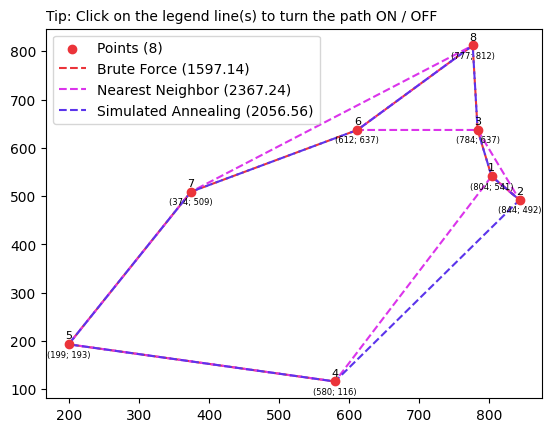

NN time: 0.000107, length: 4648.87
SA time: 0.013909, length: 4033.10


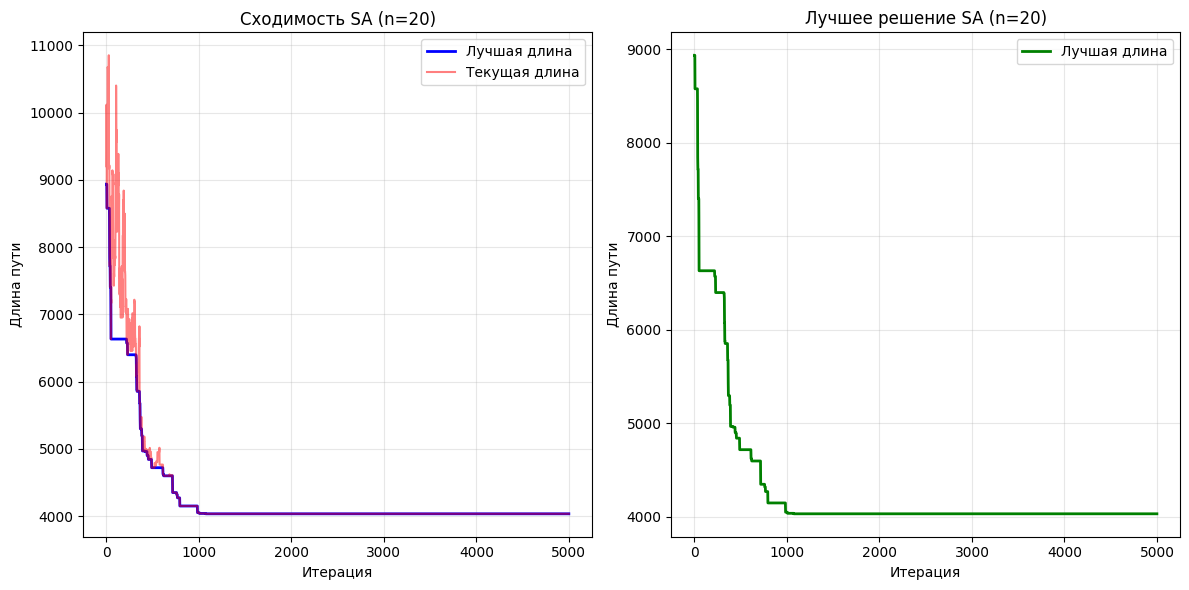

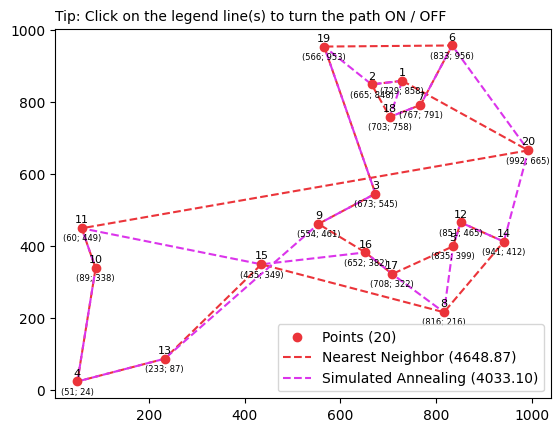

NN time: 0.002005, length: 9268.63
SA time: 0.058009, length: 15587.42

Сводная таблица результатов:
Размер задачи  NN время (с)    NN длина  SA время (с)     SA длина BF время (с)    BF длина
          n=8      0.000031 2367.239670      0.002048  2056.562049     0.019513  1597.13632
         n=20      0.000107 4648.865193      0.013909  4033.102746            -           -
        n=100      0.002005 9268.625673      0.058009 15587.419867            -           -


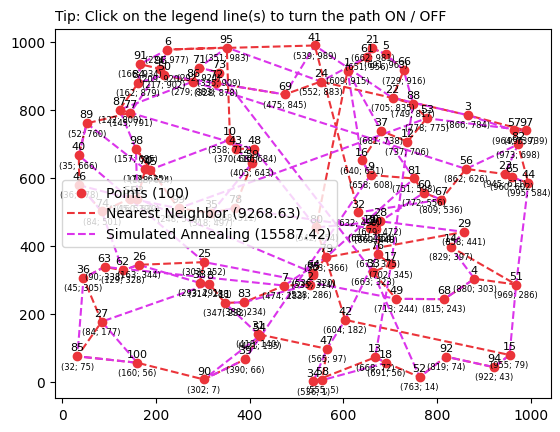

In [94]:
if __name__ == "__main__":
    small_points = generate_problem(8, 1000)
    
    start_time = time.time()
    bf_path = BF().run(small_points, "Brute Force")
    bf_time = time.time() - start_time
    
    start_time = time.time()
    nn_path = NN().run(small_points, "Nearest Neighbor")
    nn_time = time.time() - start_time
    
    start_time = time.time()
    sa_path = SA(iter=1000, t=1000, g=0.99).run(small_points, "Simulated Annealing")
    sa_time = time.time() - start_time
    
    print(f"BF time: {bf_time:.6f}, length: {bf_path.leng:.2f}")
    print(f"NN time: {nn_time:.6f}, length: {nn_path.leng:.2f}")
    print(f"SA time: {sa_time:.6f}, length: {sa_path.leng:.2f}")
    
    TSP(small_points, [bf_path, nn_path, sa_path])
    
    medium_points = generate_problem(20, 1000)
    
    start_time = time.time()
    nn_path_medium = NN().run(medium_points, "Nearest Neighbor")
    nn_time_medium = time.time() - start_time
    
    sa_with_conv = SAWithConvergence(iter=5000, t=1000, g=0.995)
    start_time = time.time()
    sa_path_medium, convergence_data = sa_with_conv.run_with_convergence(medium_points, "Simulated Annealing")
    sa_time_medium = time.time() - start_time
    
    print(f"NN time: {nn_time_medium:.6f}, length: {nn_path_medium.leng:.2f}")
    print(f"SA time: {sa_time_medium:.6f}, length: {sa_path_medium.leng:.2f}")
    
    iterations = [data['iteration'] for data in convergence_data]
    best_lengths = [data['best_length'] for data in convergence_data]
    current_lengths = [data['current_length'] for data in convergence_data]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(iterations, best_lengths, 'b-', label='Лучшая длина', linewidth=2)
    plt.plot(iterations, current_lengths, 'r-', alpha=0.5, label='Текущая длина')
    plt.xlabel('Итерация')
    plt.ylabel('Длина пути')
    plt.title('Сходимость SA (n=20)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(iterations, best_lengths, 'g-', label='Лучшая длина', linewidth=2)
    plt.xlabel('Итерация')
    plt.ylabel('Длина пути')
    plt.title('Лучшее решение SA (n=20)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    TSP(medium_points, [nn_path_medium, sa_path_medium])
    
    large_points = generate_problem(100, 1000)
    
    start_time = time.time()
    nn_path_large = NN().run(large_points, "Nearest Neighbor")
    nn_time_large = time.time() - start_time
    
    start_time = time.time()
    sa_path_large = SA(iter=10000, t=1000, g=0.999).run(large_points, "Simulated Annealing")
    sa_time_large = time.time() - start_time
    
    print(f"NN time: {nn_time_large:.6f}, length: {nn_path_large.leng:.2f}")
    print(f"SA time: {sa_time_large:.6f}, length: {sa_path_large.leng:.2f}")
    
    summary_data = {
        'Размер задачи': ['n=8', 'n=20', 'n=100'],
        'NN время (с)': [nn_time, nn_time_medium, nn_time_large],
        'NN длина': [nn_path.leng, nn_path_medium.leng, nn_path_large.leng],
        'SA время (с)': [sa_time, sa_time_medium, sa_time_large],
        'SA длина': [sa_path.leng, sa_path_medium.leng, sa_path_large.leng]
    }
    
    if 'bf_time' in locals():
        summary_data['BF время (с)'] = [bf_time, '-', '-']
        summary_data['BF длина'] = [bf_path.leng, '-', '-']
    
    df_summary = pd.DataFrame(summary_data)
    print("\nСводная таблица результатов:")
    print(df_summary.to_string(index=False))
    
    TSP(large_points, [nn_path_large, sa_path_large])